### IMPORTS

In [120]:
from Inference import BBVI 

In [121]:
import torch
import matplotlib.pyplot as plt
import _pickle as pickle

### EXAMPLE

In [123]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [124]:
# load data
data = torch.load('C:\\Users\\cortax\\Documents\\BayesianNN\\data\\foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [125]:
data = torch.load('C:\\Users\\cortax\\Documents\\BayesianNN\\data\\foong_data_validation.pt')
x_data_validation = data[0].to(device)
y_data_validation = data[1].to(device)
y_data_validation = y_data_validation.unsqueeze(-1)

In [126]:
data = torch.load('C:\\Users\\cortax\\Documents\\BayesianNN\\data\\foong_data_test.pt')
x_data_test = data[0].to(device)
y_data_test = data[1].to(device)
y_data_test = y_data_test.unsqueeze(-1)

In [127]:
filename = 'C:\\Users\\cortax\\Documents\\BayesianNN\\Experiments\\foong\\tanh\\MAP\\models\\' + '3Layers_50Neurons_(0)'
filehandler = open(filename, 'rb')
netparam = pickle.load(filehandler)

In [128]:
Net = BBVI.VariationalNetwork(input_size=netparam['input_size'],
                              output_size=netparam['output_size'],
                              layer_width=netparam['layer_width'],
                              nb_layers=netparam['nb_layers'])
Net.set_network(netparam)
Net.set_device(device)

In [129]:
#Net.requires_grad_mus(False)

In [130]:
model = Net

In [131]:
model.sample_parameters(1000)
y_train = model.forward(x_data).to(device) 

y_validation = model.forward(x_data_validation).to(device)
y_test = model.forward(x_data_test).to(device)

RuntimeError: CUDA out of memory. Tried to allocate 1.86 GiB (GPU 0; 4.00 GiB total capacity; 2.78 GiB already allocated; 194.55 MiB free; 92.87 MiB cached)

In [132]:
ELL_train = model._log_norm(y_train, y_data, torch.tensor(0.1).to(device))
ELL_train = ELL_train.sum(dim=[1,2]).mean().detach().cpu().numpy()


ELL_val = model._log_norm(y_validation, y_data_validation, torch.tensor(0.1).to(device))
ELL_val = ELL_val.sum(dim=[1,2]).mean().detach().cpu().numpy()

ELL_test = model._log_norm(y_test, y_data_test, torch.tensor(0.1).to(device))
ELL_test = ELL_test.sum(dim=[1,2]).mean().detach().cpu().numpy()

ELBO_train = model.compute_elbo(x_data, y_data, n_samples_ELBO=1000, sigma_noise=0.1, device=device).detach().cpu().numpy()
ELBO_val = model.compute_elbo(x_data_validation, y_data_validation, n_samples_ELBO=1000, sigma_noise=0.1, device=device).detach().cpu().numpy()
ELBO_test = model.compute_elbo(x_data_test, y_data_test, n_samples_ELBO=1000, sigma_noise=0.1, device=device).detach().cpu().numpy()

RuntimeError: The size of tensor a (100) must match the size of tensor b (10000) at non-singleton dimension 1

Text(-1.7, -0.25, 'ELBO (test): 279712.4')

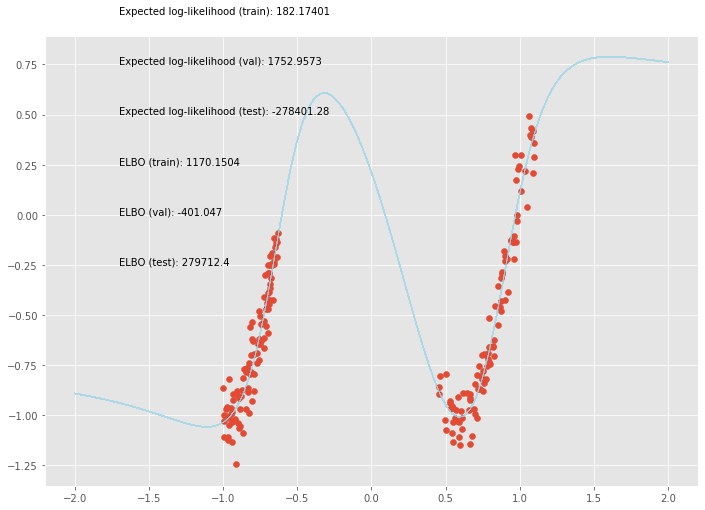

In [113]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')
plt.text(-1.7, 3-2, 'Expected log-likelihood (train): '+str(ELL_train), fontsize=10)
plt.text(-1.7, 2.75-2, 'Expected log-likelihood (val): '+str(ELL_val), fontsize=10)
plt.text(-1.7, 2.5-2, 'Expected log-likelihood (test): '+str(ELL_test), fontsize=10)
plt.text(-1.7, 2.25-2, 'ELBO (train): '+ str(ELBO_train), fontsize=10)
plt.text(-1.7, 2-2, 'ELBO (val): '+ str(ELBO_val), fontsize=10)
plt.text(-1.7, 1.75-2, 'ELBO (test): '+ str(ELBO_test), fontsize=10)    

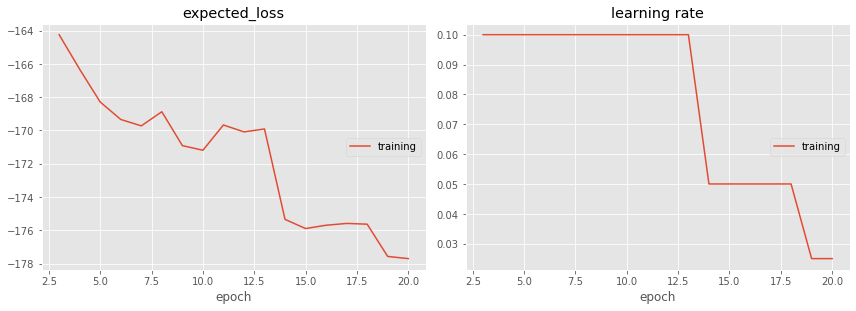

expected_loss:
training   (min: -177.696, max:  869.203, cur: -177.696)

learning rate:
training   (min:    0.025, max:    0.100, cur:    0.025)


In [117]:
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.1}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 2, 'factor': 0.5}

voptimizer = BBVI.VariationalOptimizer(model=Net, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params, min_lr=0.00001)
Net = voptimizer.run((x_data,y_data), n_epoch=20, n_iter=150, n_ELBO_samples=75, plot=True)

In [118]:
model.sample_parameters(1000)
y_train = model.forward(x_data).to(device) 

y_validation = model.forward(x_data_validation).to(device)
y_test = model.forward(x_data_test).to(device)

ELL_train = model._log_norm(y_train, y_data, torch.tensor(0.1).to(device))
ELL_train = ELL_train.sum(dim=[1,2]).mean().detach().cpu().numpy()


ELL_val = model._log_norm(y_validation, y_data_validation, torch.tensor(0.1).to(device))
ELL_val = ELL_val.sum(dim=[1,2]).mean().detach().cpu().numpy()

ELL_test = model._log_norm(y_test, y_data_test, torch.tensor(0.1).to(device))
ELL_test = ELL_test.sum(dim=[1,2]).mean().detach().cpu().numpy()

ELBO_train = model.compute_elbo(x_data, y_data, n_samples_ELBO=1000, sigma_noise=0.1, device=device).detach().cpu().numpy()
ELBO_val = model.compute_elbo(x_data_validation, y_data_validation, n_samples_ELBO=1000, sigma_noise=0.1, device=device).detach().cpu().numpy()
ELBO_test = model.compute_elbo(x_data_test, y_data_test, n_samples_ELBO=1000, sigma_noise=0.1, device=device).detach().cpu().numpy()

Text(-1.7, -0.25, 'ELBO (test): 320737.72')

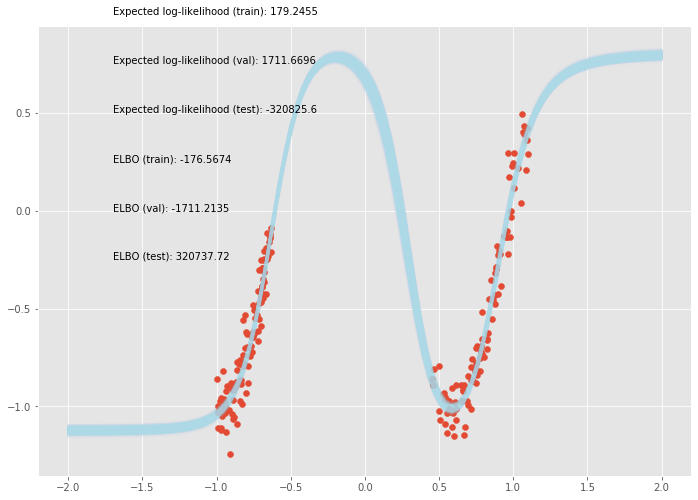

In [119]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')
plt.text(-1.7, 3-2, 'Expected log-likelihood (train): '+str(ELL_train), fontsize=10)
plt.text(-1.7, 2.75-2, 'Expected log-likelihood (val): '+str(ELL_val), fontsize=10)
plt.text(-1.7, 2.5-2, 'Expected log-likelihood (test): '+str(ELL_test), fontsize=10)
plt.text(-1.7, 2.25-2, 'ELBO (train): '+ str(ELBO_train), fontsize=10)
plt.text(-1.7, 2-2, 'ELBO (val): '+ str(ELBO_val), fontsize=10)
plt.text(-1.7, 1.75-2, 'ELBO (test): '+ str(ELBO_test), fontsize=10)   

In [110]:
Net.linear2.q_weight_rho

Parameter containing:
tensor([[-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10., -10., -10., -10.]],
       requires_grad=True)